# 2 Use pre-trained BERT for sentiment analysis

For the predictive model I use pretrained bidirectional transformer [BERT](https://huggingface.co/transformers/model_doc/bert.html).

## 2.1 Creating of Training and Validation sets

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
#import tensorflow_addons as tfa 

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels= 5)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

plt.style.use('seaborn-white')
%matplotlib inline

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The random number seed for shuffling the training set should be used for maintaining shuffling in the case of Python runtime not keeping it's state between epochs (e.g. [Google Colab](https://colab.research.google.com)):

In [28]:
seed_trainset = 123

In [3]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


Loading clean and deduplicated dataset (**only first 10000 rows, for actual training remove the limitation**):

In [4]:
df_dedup = pd.read_csv("./ReviewsDedupLowNT.csv.zip", compression="zip", index_col=0, nrows=10000)

In [5]:
df_dedup.tail(10)

,Text,Summary,Score,HelpfulnessNumerator,HelpfulnessDenominator
9990,"ah mint. my wife and i both adore mint, but im...",a shamrock whatnow?,5,0,0
9991,ah the controversial swheat scoops litter! do...,doesnt work well with litter robot ii,3,0,0
9992,ah! how time flies! growing up in a family sca...,chilfhood memories relived,5,4,4
9993,"ah, indomie mi goreng. the crack of the ramen...",the worlds most addictive ramen,5,8,8
9994,"ah, millstone entered our lives when the super...",smell tastes divine!,5,0,0
9995,"ah, tim burton before he started taking himsel...","freaky, silly, wry and creative",5,0,0
9996,"ah, a mallomar...or two...or three...or the en...",mallomars are the best!,5,1,1
9997,"ah, finally, a treat that jp, my dog loves. we...",veterinarian review,5,0,0
9998,"ah, its the old rule that things that taste go...",grams fat in tablespoons...and lots of suga...,2,2,2
9999,"ah, my favorite......i have fibromyalgia and t...",kirkland signature ito en match blend green tea,5,0,0


As the first step a model predicting review score based on the review text will be created.

In [6]:
text_labels = df_dedup.drop(columns=["Summary", "HelpfulnessNumerator", "HelpfulnessDenominator"])
text_labels = text_labels.rename(columns={"Text": "DATA_COLUMN", "Score": "LABEL_COLUMN"})
text_labels["LABEL_COLUMN"] = text_labels["LABEL_COLUMN"] - 1

In [7]:
text_labels.tail()

,DATA_COLUMN,LABEL_COLUMN
9995,"ah, tim burton before he started taking himsel...",4
9996,"ah, a mallomar...or two...or three...or the en...",4
9997,"ah, finally, a treat that jp, my dog loves. we...",4
9998,"ah, its the old rule that things that taste go...",1
9999,"ah, my favorite......i have fibromyalgia and t...",4


The dataset is splitted into train (80% samples) and validation (20%) sets: 

In [8]:
train = text_labels.sample(frac=0.8,random_state=123)
test = text_labels.drop(train.index)

For training of the BERT model the dataset samples should be converted to the *InputExample* objects, containing

- *guid* - unique id for the example (not used)
- *text_a* (string) - the untokenized text of the first sequence
- *text_b* (optional, string) - the untokenized text of the second sequence (not used)
- label (optional, int) - The label of the example

and assembled to the TensorFlow datasets *train_data* and *validation_data*:

In [12]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None,
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None,
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
    return train_InputExamples, validation_InputExamples

    train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')

def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True, # Add [CLS] and [SEP]
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [13]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(buffer_size=1000, seed=seed_trainset).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Treating imbalance

The classes in our dataset are highly imbalanced. Rating 5(Class 4) is over 60 percent of all examples with the other classes hovering around 10 percent. In order to mitigate the impact of an unbalanced training set the [*SparseCategoricalFocalLoss*](https://focal-loss.readthedocs.io/en/latest/generated/focal_loss.SparseCategoricalFocalLoss.html#focal_loss.SparseCategoricalFocalLoss) loss function is used. This function generalizes multiclass softmax cross-entropy by introducing a hyperparameter called the focusing parameter that allows hard-to-classify examples to be penalized more heavily relative to easy-to-classify examples.

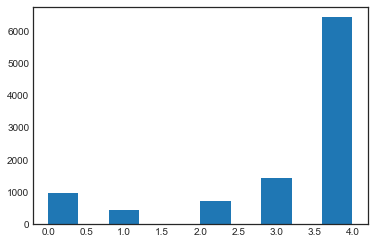

In [32]:
plt.hist(text_labels["LABEL_COLUMN"]);

In [31]:
%run SparseCategoricalFocalLoss.py

For the proper use of the *SparseCategoricalFocalLoss* loss function the *weights*, or classes distribution in the training set should be calculated:

In [29]:
num_classes = text_labels["LABEL_COLUMN"].nunique()
classes_dist = []
n_of_class = text_labels.groupby("LABEL_COLUMN")
for i in range(num_classes):
    classes_dist.append(len(n_of_class.groups[i])/len(text_labels))
weights = tf.convert_to_tensor(classes_dist, dtype=tf.float32)

The actual model has been trained on the [Google Colab](https://colab.research.google.com) free runtime. In order to feed the model with different training sets across the epochs *seed_trainset* random seed should be changed. The variation of *learning_rate* parameter between 1e-5 and 4e-5 as well as *gamma* power from 1 to 4 did not affected validation accuracy significantly. The *amazon_my_trained_FL_G_k7e12ac78L03vac75VL04g2lr4* model was trained within 12 epochs, 11 epochs with 2000 steps and the last epoch with 7000 steps (about 7% of original training set used for the training). The training step time for the given batch size was about 400 ms for P100 GPU and 800 ms for T4 GPU. The validation set accuracy along the epochs was around 75%.

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=SparseCategoricalFocalLoss(gamma=2, class_weight=weights, from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [35]:
#model.fit(train_data, epochs=1, validation_data=validation_data)

In [36]:
model.load_weights("./amazon_my_trained_FL_G_k7e12ac78L03vac75VL04g2lr4")

The model confusion matrix for the 400 samples validation subset is following: 

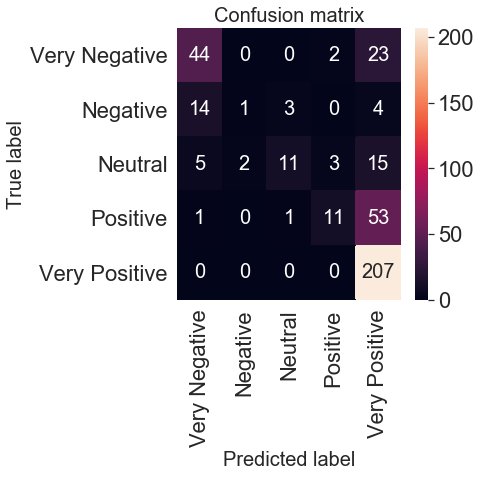

accuracy for 400-element validation subset is 0.685.


In [62]:
# Using tf.keras.losses.SparseCategoricalCrossentropy() loss function
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)


tf_batch = tokenizer(test["DATA_COLUMN"].tolist()[0:400], max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
predictions = tf.nn.softmax(tf_outputs[0], axis=-1)

y_test = test["LABEL_COLUMN"].tolist()[0:400]               
                     
LABELS = ['Very Negative','Negative','Neutral','Positive','Very Positive']

#X_test = test["DATA_COLUMN"]
#y_test = test["LABEL_COLUMN"]
#predictions = model.predict(X_test, batch_size=1000)
#max_test = np.argmax(y_test, axis=1)

max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(y_test, max_predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

values = confusion_matrix.view()
error_count = values.sum() - np.trace(values)
accuracy = 1.0 - error_count/max_predictions.size
print("accuracy for {0}-element validation subset is {1}.".format(max_predictions.size, accuracy))

One can see, that mostly neighboring scored elements are misclassified.
However a substentional number of *Very Negative* samples were missclassified as *Very Positive*.
Let's take a look at such samples:

In [95]:
BadAsGood = test["DATA_COLUMN"][0:max_predictions.size].loc[
    (max_predictions==4)&(test["LABEL_COLUMN"][0:max_predictions.size]==0)].tolist()

In [98]:
print(BadAsGood[0])

all good things must come to an end and the end of the great season sardines is now.  previous years season sardines were too good.  season manischewitz co. no longer gets these sardines from norway.  now they supply low grade sardines from scotland canners.  last year, these were the best northern sardines available now they are inedible.  amazons web page is in error . . . the package now says product of scotland.they also switched to a much lower grade oil, pure instead of extra virgin.  it doesnt even taste like olive oil.  the fish have a poor texture and worse flavor.  i couldnt finish one can.  other sardine brands have switched from norwegian to scottish suppliers to reduce cost before.  these are among the lowest quality commodity sardines available.  anything in your local store has better flavor and texture.  these season sardines are rubbery and seem underdone.please understand im not just saying these are not up to their previous high standard.  im saying these season sard

In [101]:
print(BadAsGood[1])

.  . shipping??  . per each?  sell these by the case and i would have tried it.  ridiculous price.


In [102]:
print(BadAsGood[2])

 for a single serving is high compared to the price offered from nutrisystem themselves. also, despite being listed as from nutrisystem, our package came from a separate source.


In [103]:
print(BadAsGood[3])

. in shipping  days for a . order!?!?!?  do the math, thats over  extra on shipping alone.  are you crazy?  were not talking about scharffen berger chocolates here and they only charge  for  to  days for a  order.  i dont care what chocolate you buy, but dont get taken on the shipping for a cheap product!!!


It looks like the model learned very expressive reviews as very positive. Another source of errors could be very long reviews containing many points with different sentiment.  